In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from joblib import load

In [2]:
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import auc, roc_curve, plot_roc_curve, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV

In [3]:
from sklearn.datasets import load_breast_cancer

# Part 1 - Sample dataset

Load sample dataset from sklearn

In [4]:
X, y = load_breast_cancer(return_X_y=True)

Separate Train and Test data

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

## Set model baseline

We will compare three models:
  1. A decision tree that will serve as a baseline model
  2. A XGBoost model

We will compare those model on the f1 score performed on the test set.

In [6]:
def train_and_output_f1_score(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = f1_score(y_test, y_pred)
    return score, model

In [7]:
decision_tree = DecisionTreeClassifier()
score_dt, dt_trained = train_and_output_f1_score(decision_tree, X_train, X_test, y_train, y_test)
print(f"Using a decision tree, the f1 score equals {score_dt:.3f}")

Using a decision tree, the f1 score equals 0.957


## Train a simple XGBoost Model

For now, let's train a XGBoost using the defaults parameters. The only one we need to select is the objective we want to achieve. The list of possible objectives is:
 - Regression model
   - `reg:squarederror`: regression with squared loss.
   - `reg:squaredlogerror`: regression with squared log loss 12[log(pred+1)−log(label+1)]2. All input labels are required to be greater than -1. Also, see metric rmsle for possible issue with this objective.
   - `reg:logistic`: logistic regression
   - `reg:pseudohubererror`: regression with Pseudo Huber loss, a twice differentiable alternative to absolute loss.
 - Binary Classification model
   - `binary:logistic`: logistic regression for binary classification, output probability
   - `binary:logitraw`: logistic regression for binary classification, output score before logistic transformation
   - `binary:hinge`: hinge loss for binary classification. This makes predictions of 0 or 1, rather than producing probabilities.
 - Multiclass Classification model
   - `multi:softmax`: set XGBoost to do multiclass classification using the softmax objective, you also need to set num_class(number of classes)
   - `multi:softprob`: same as softmax, but output a vector of ndata * nclass, which can be further reshaped to ndata * nclass matrix. The result contains predicted probability of each data point belonging to each class.



Our sample problem is a binary classification problem. We want to predict the probability of being diagnosed with cancer, so our objective will be `binary:logisitic`.

In [8]:
xgboost_model = xgb.XGBClassifier(objective='binary:logistic')

We now score our model based on the same test data.

In [9]:
score_xgb, xgboost_trained = train_and_output_f1_score(xgboost_model, X_train, X_test, y_train, y_test)
print(f"Using a non-optimized XGBoost Mode, the f1 score equals {score_xgb:.3f}")

Using a non-optimized XGBoost Mode, the f1 score equals 0.981


## Hyperparameter Tuning - XGBoost Model

The goal is now to improve the XGboost model by carefully optimizing the model parameters. For this, we are going to perform a cross-validation using the built-in sklearn framework.

We need first to setup the cross-validation fold. We are going to split the training set in three folds. Two of those folds will be used to train the model and the third one will be used for scoring.

In [10]:
kf = StratifiedKFold(n_splits=3)

Parameters to optimize during the hyper-parameter training:

**Control Model Complexity**
 1. `gamma`: Minimum loss reduction required to make a further partition on a leaf node of the tree. 
    Increasing this parameter *decreases* the variance.
 2. `max_depth`: Maximum depth of a tree.
    Increasing this parameter *increases* the variance.
 3. `min_child_weight`: Minimum sum of instance weight needed in a child.
    Increasing this parameter *decreases* the variance.

**Add randomness**
 4. `colsample_bytree`: subsample ratio of columns when constructing each tree.
    Increasing this parameter *increases* the variance.
 5. `subsample`:  ratio of the training instances to consider.
    Increasing this parameter *increases* the variance.


**Add Regularization**
 4. `alpha`: L1 regularization term on weights.
    Increasing this parameter *decreases* the variance.

In [11]:
# Let's define the parameters we want to optimize

param_grid = {
    'max_depth': [4, 8, 10],
    'min_child_weight': [1, 4, 6],
    'gamma':[0, 0.001, 10],
    'alpha':[0, 0.001, 10],
    'colsample_bytree': [0.6, 1],
    'subsample': [0.6, 1]
}

Based on this parameter grid, we will perform:
 - 3 * 3 * 3 * 3 * 2 * 2 = 324 feasible combinations
 - 324 * 3 = 972 fits (because we are scoring each fitted model on each cross-validation fold).

We now setup the GridSearchCV optimizer. This is a scikit-learn class that also works with XGBoost. It performs a cross-validation on the training set to find the optimal parameters among those provided in the parameter grid above.

In [12]:
estimator = xgb.XGBClassifier(objective='binary:logistic', # learning task: binary classification, outputs probability
                              nthread=4)
                                                     
gsearch1 = GridSearchCV(estimator,
                        param_grid = param_grid,
                        scoring='f1',
                        n_jobs=4,
                        cv=kf,
                        verbose=10)

In [13]:
gsearch1.fit(X_train, y_train)

Fitting 3 folds for each of 324 candidates, totalling 972 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Batch computation too fast (0.1931s.) Setting batch_size=2.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done  34 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Batch computation too fast (0.1476s.) Setting batch_size=4.
[Parallel(n_jobs=4)]: Done  56 tasks      | elapsed:    2.5s
[Parallel(n_jobs=4)]: Done 100 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done 144 tasks      | elapsed:    3.9s
[Parallel(n_jobs=4)]: Done 196 tasks      | elapsed:    4.9s
[Parallel(n_jobs=4)]: Done 248 tasks      | elapsed:    5.8s
[Parallel(n_jobs=4)]: Done 308 tasks      | elapsed:    7.2s
[Parallel(n_jobs=4)]: Done 368 tasks      | elapsed:    8.1s
[Parallel(n_jobs=4)]: Done 43

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=XGBClassifier(nthread=4), n_jobs=4,
             param_grid={'alpha': [0, 0.001, 10], 'colsample_bytree': [0.6, 1],
                         'gamma': [0, 0.001, 10], 'max_depth': [4, 8, 10],
                         'min_child_weight': [1, 4, 6], 'subsample': [0.6, 1]},
             scoring='f1', verbose=10)

The best parameters are highlighted below

In [14]:
cv_params = gsearch1.best_params_
print(cv_params)

{'alpha': 0, 'colsample_bytree': 1, 'gamma': 0, 'max_depth': 4, 'min_child_weight': 1, 'subsample': 0.6}


We can fit the model on the entire training set using the parameters found during the cross-validation.

In [15]:
xgboost_model = xgb.XGBClassifier(objective='binary:logistic', **cv_params)
score_xgb_cv, xgboost_opt = train_and_output_f1_score(xgboost_model, X_train, X_test, y_train, y_test)
print(f"Using an optimized XGBoost model, the f1 score equals {score_xgb_cv:.3f}")

Using an optimized XGBoost model, the f1 score equals 0.990


## Models comparison

The scores are summarized in the following table

| Decision Tree | XGBoost | Optimized XGBoost |
| :-----------: | ------------- | ----------------- |
| 0.947 | 0.976 | 0.990 |

Because this is a binary classification problem, we can plot the ROC curves and the Area under the curve. The higher the area under the curve is, the better the model.

In [16]:
type(0) == int

True

In [17]:
def plot_roc_curve(model, X_test, y_test, ax, legend):
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred = model.predict(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

    if type(y_pred[0]) != np.int32:
        y_pred = np.where(y_pred == 'tumor', 1, 0)

    roc_auc = f1_score(y_test, y_pred)
    ax.plot(fpr, tpr, label=f'{legend} (f1 score = {roc_auc:.3f})')

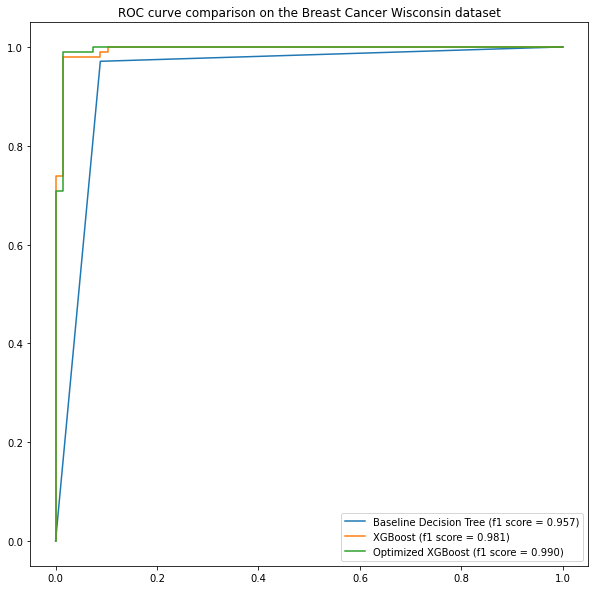

In [18]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_roc_curve(dt_trained, X_test, y_test, ax=ax, legend='Baseline Decision Tree')
plot_roc_curve(xgboost_trained, X_test, y_test, ax=ax, legend='XGBoost')
plot_roc_curve(xgboost_opt, X_test, y_test, ax=ax, legend='Optimized XGBoost')
ax.set_title("ROC curve comparison on the Breast Cancer Wisconsin dataset")
ax.legend();

# Part 2 - _Build Hackathon Training Data

Download data from Google Cloud Storage

In [6]:
url = "gs://build_hackathon_dnanyc/training_data/binary_data/binary_dataset.csv"
df = pd.read_csv(url)

In [7]:
df.shape

(13990, 5001)

Create train and test set

In [20]:
# Create X and y matrices
X, y = df.drop('labels', axis=1).values, df['labels'].values

# Transform y to get 1 when the observation is cancerous and 0 if not
y = np.where(y == 'tumor', 1, 0)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

## Set Model Baseline

As previously, we are using a Decision Tree Classifier as a model baseline

In [22]:
decision_tree = DecisionTreeClassifier()
score_dt, dt_trained = train_and_output_f1_score(decision_tree, X_train, X_test, y_train, y_test)
print(f"Using a decision tree, the f1 score equals {score_dt:.3f}")

Using a decision tree, the f1 score equals 0.979


## Train a simple XGBoost Model

We are then fitting a XGBoost model using defaults parameters.

In [23]:
xgboost_model = xgb.XGBClassifier(objective='binary:logistic')

In [24]:
score_xgb, xgboost_trained = train_and_output_f1_score(xgboost_model, X_train, X_test, y_train, y_test)
print(f"Using a non-optimized XGBoost Mode, the f1 score equals {score_xgb:.3f}")

Using a non-optimized XGBoost Mode, the f1 score equals 0.995


## Hyperparameter Tuning - XGBoost Model

We could do exactly the same as before to go through the parameter grid and set the hyperparameter. But doing this on a single machine would take hours. Instead, we used the AI Platform on GCP to train the model and optimize the hyperparameters.

At the end of the process, we can download the model from Google Cloud Storage and using the `joblib` library to load back the model into our environment.

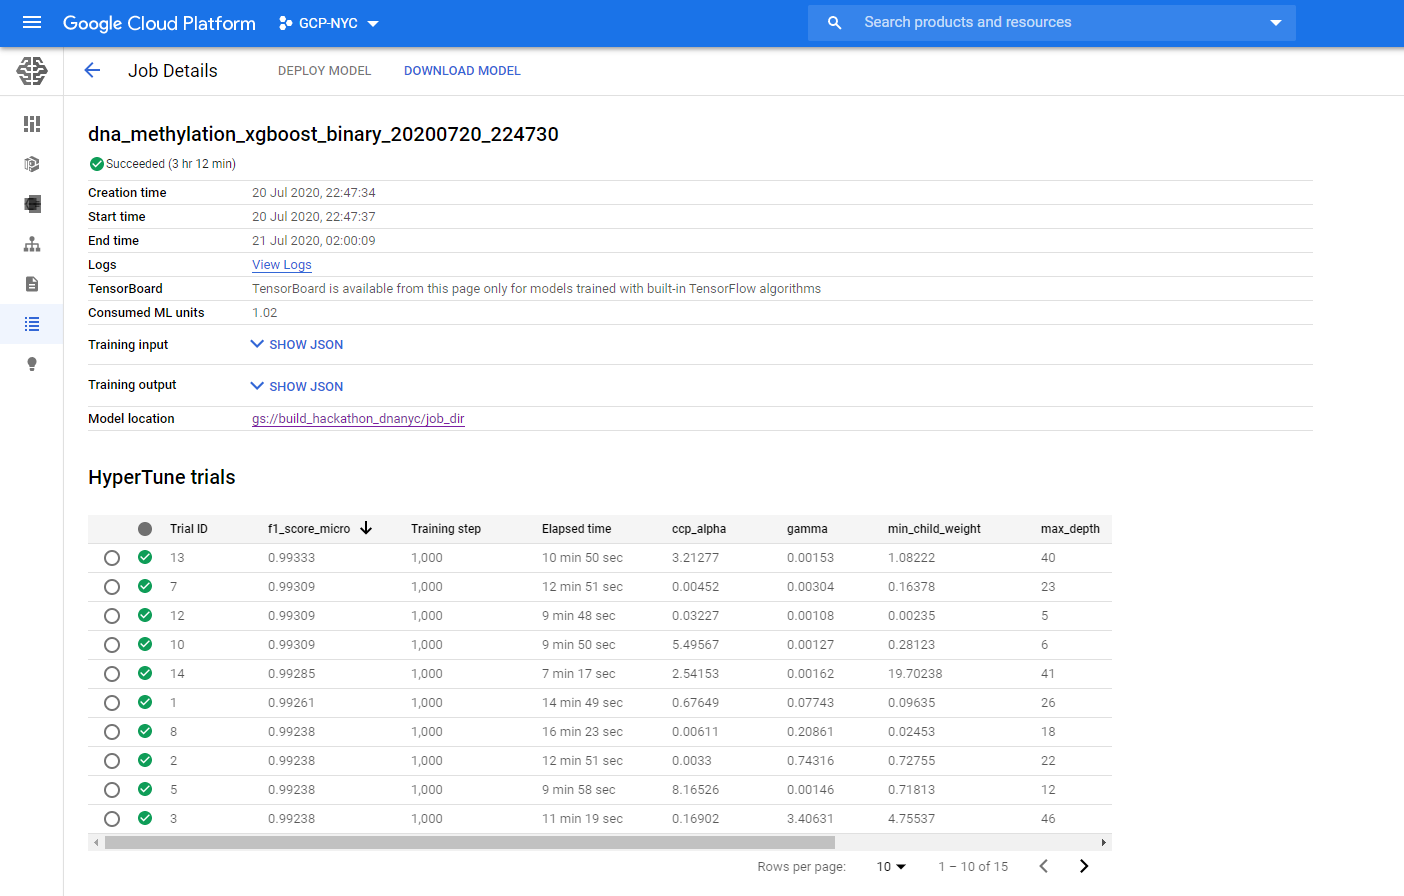

Download the saved model from GCS

In [25]:
url = 'https://storage.googleapis.com/build_hackathon_dnanyc/job_dir/13/model-binary-xgboost-21-micro.joblib'
saved_model = requests.get(url)
filename = 'xgboost_model.joblib'
with open(filename, 'wb') as f:
    f.write(saved_model.content)

Then, load the saved model using the joblib library

In [26]:
xgboost_model_opt = load('xgboost_model.joblib')

# Test the model performance on the test data
y_pred = xgboost_model_opt.predict(X_test)
y_pred = np.where(y_pred == 'tumor', 1, 0)

score_xgboost_opt = f1_score(y_pred, y_test)
print(f"Using the optimized XGBoost model, the f1 score on the test data is {score_xgboost_opt:.3f}")

C:\Users\adrien.galamez\Miniconda3\envs\DNA_Methylation\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.22.1 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


Using the optimized XGBoost model, the f1 score on the test data is 0.995


## Models comparison

The scores are summarized in the following table

| Decision Tree | XGBoost | Optimized XGBoost |
| :-----------: | ------------- | ----------------- |
| 0.976 | 0.993 | 0.998 |

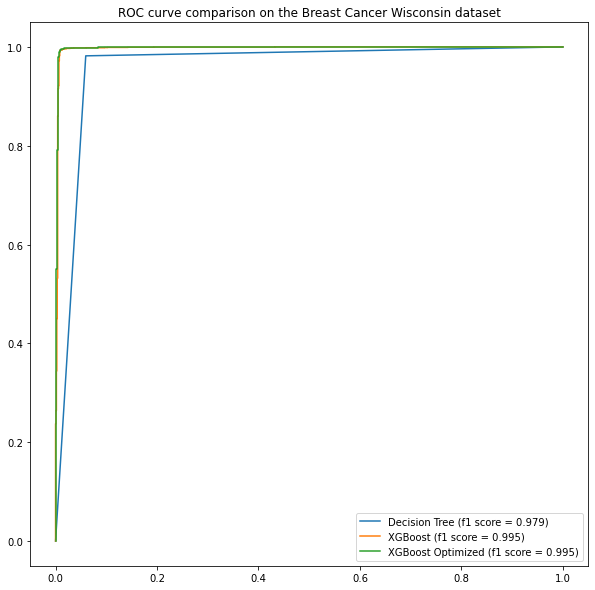

In [27]:
fig, ax = plt.subplots(figsize=(10, 10))

# Plot DecisionTree curve
plot_roc_curve(dt_trained, X_test, y_test, ax=ax, legend='Decision Tree')
# Plot Xgboost model curve
plot_roc_curve(xgboost_trained, X_test, y_test, ax=ax, legend='XGBoost')
# Plot optimized XGBoost model curve
plot_roc_curve(xgboost_model_opt, X_test, y_test, ax=ax, legend='XGBoost Optimized')

# Set matplotlib parameters
ax.set_title("ROC curve comparison on the Breast Cancer Wisconsin dataset")
ax.legend();